1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.special import factorial
import pandas as pd

%matplotlib notebook

Absolute minima:

[-6.86148911e-09] [-0.73649881]
[-6.86148911e-09] [0.73649867]


<IPython.core.display.Javascript object>


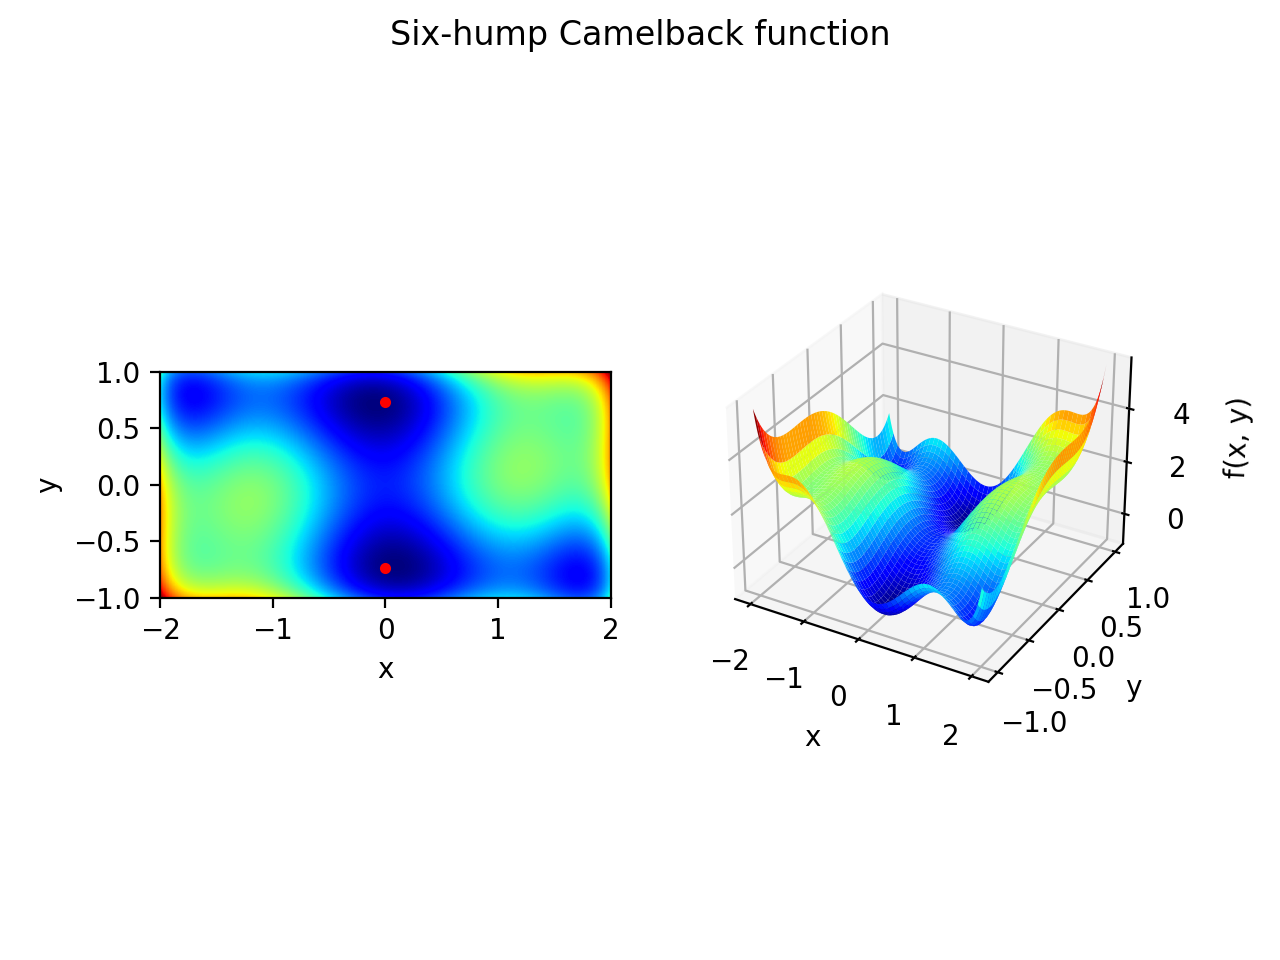

Text(0, 0.5, 'y')

In [37]:
def camelback(x,y):
    return (4 - 2.1 * x**2 + (x**4)/3)*x**2 +x*y +(4*y**2 -4)*y**2

x=np.linspace(-2,2,300)
y=np.linspace(-1,1,300)

# optimization x
optimization = optimize.minimize(camelback,[1], args=(0,)) 
best_x = optimization.x

# optimization y
optimization = optimize.minimize(lambda x,y: camelback(y,x), [1], args=(0.5,))
best_y1 = optimization.x

optimization = optimize.minimize(lambda x,y: camelback(y,x), [1], args=(-0.5,))
best_y2 = optimization.x

print('Absolute minima:\n')
print(best_x,best_y1)
print(best_x,best_y2)


fig=plt.figure()
fig.suptitle('Six-hump Camelback function')
ax1=fig.add_subplot(1, 2, 2, projection='3d')
ax2=fig.add_subplot(1, 2, 1)

xx,yy=np.meshgrid(x,y)
zz=camelback(xx,yy)

ax1.plot_surface(xx,yy,zz,cmap=plt.cm.jet)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')

ax2.imshow(camelback(xx,yy),cmap=plt.cm.jet, extent=[-2, 2, -1, 1],origin="lower")
ax2.scatter([best_x], [best_y1], c='r',marker='.');
ax2.scatter([best_x], [best_y2], c='r',marker='.');
ax2.set_xlabel('x')
ax2.set_ylabel('y')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Fitting function expression: a*cos(x*b+c)+d 

Parametres for max temperature fit:
 [-10.58169955  -0.59227423   7.12331894  27.94963524]
a = -10.58 +- 0.41
b = -0.59 +- 0.02
c = 7.12 +- 0.15
d = 27.95 +- 0.43 

Parametres for min temperature fit:
 [-25.14962061  -0.60132051  -5.13556143 -36.71257798]
a = -25.15 +- 1.31
b = -0.60 +- 0.02
c = -5.14 +- 0.16
d = -36.71 +- 1.19 



<IPython.core.display.Javascript object>


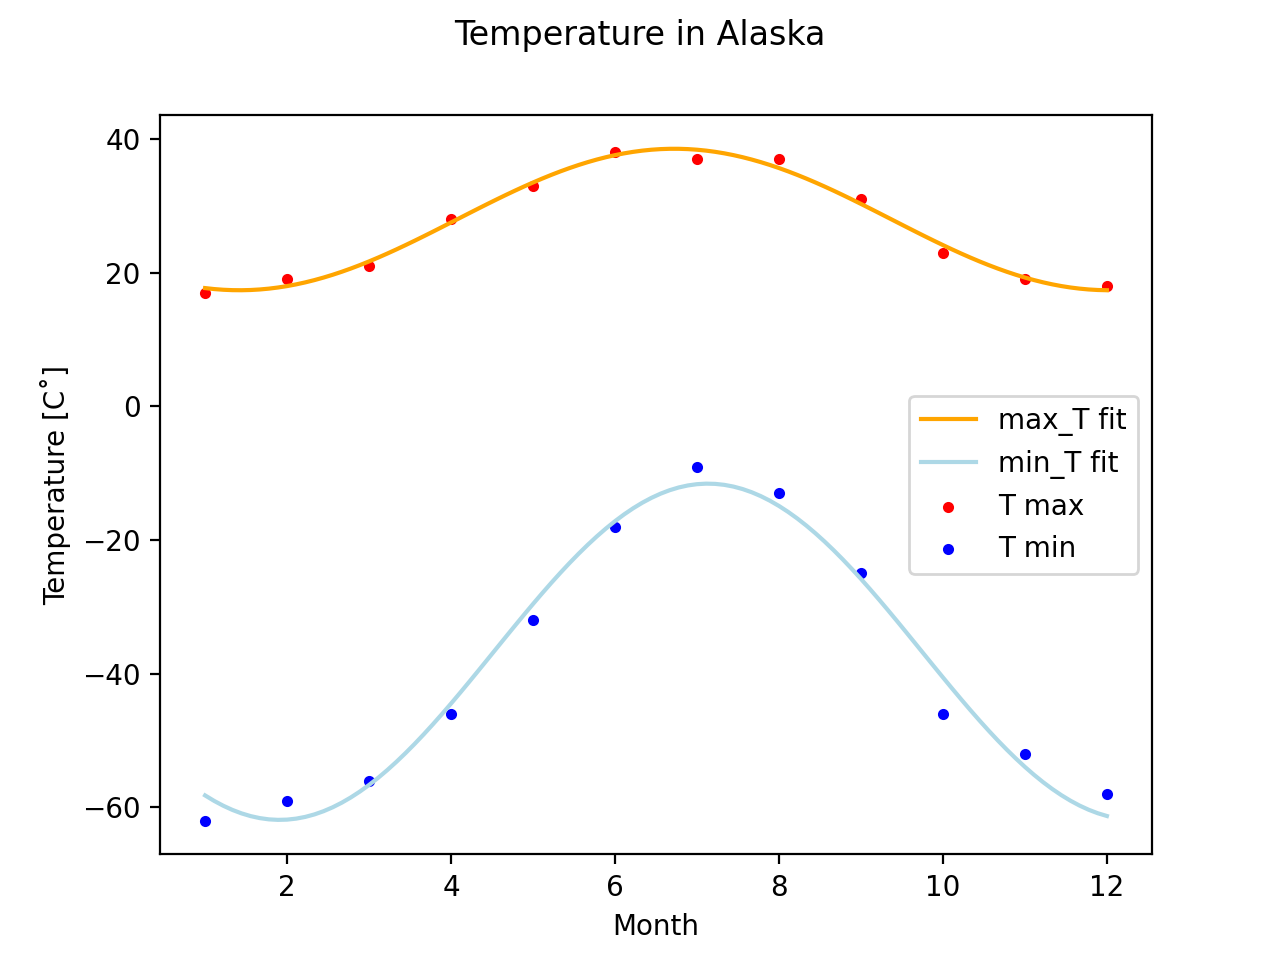

In [43]:
month=np.array([i for i in range(1,13)])
t_max=(17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18)
t_min=(-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58)

def f(x,a,b,c,d):
    return a*np.cos(x*b+c)+d

print('Fitting function expression: a*cos(x*b+c)+d \n')

popt_max, pcov_max = curve_fit(f, month, t_max)
print('Parametres for max temperature fit:\n', popt_max)
print("a = %.2f +- %.2f" % (popt_max[0], np.sqrt(pcov_max[0,0])))
print("b = %.2f +- %.2f" % (popt_max[1], np.sqrt(pcov_max[1,1])))
print("c = %.2f +- %.2f" % (popt_max[2], np.sqrt(pcov_max[2,2])))
print("d = %.2f +- %.2f" % (popt_max[3], np.sqrt(pcov_max[3,3])),'\n')

popt_min, pcov_min = curve_fit(f, month, t_min)
print('Parametres for min temperature fit:\n', popt_min)
print("a = %.2f +- %.2f" % (popt_min[0], np.sqrt(pcov_min[0,0])))
print("b = %.2f +- %.2f" % (popt_min[1], np.sqrt(pcov_min[1,1])))
print("c = %.2f +- %.2f" % (popt_min[2], np.sqrt(pcov_min[2,2])))
print("d = %.2f +- %.2f" % (popt_min[3], np.sqrt(pcov_min[3,3])),'\n')

x_range=np.linspace(1,12,100)

fig=plt.figure()
fig.suptitle('Temperature in Alaska')
ax=fig.add_subplot()

ax.scatter(month,t_max, marker='.',c='r',label='T max')
ax.plot(x_range, f(x_range,*popt_max), c='orange', label='max_T fit')

ax.scatter(month,t_min, marker='.',c='b',label='T min')
ax.plot(x_range, f(x_range,*popt_min), c='lightblue',label='min_T fit')

ax.legend(loc='best')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature [C˚]')
fig.show()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [9]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/


--2021-12-28 11:18:04--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-28 11:18:04--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc81a723f36cdce061beee97828c.dl.dropboxusercontent.com/cd/0/inline/Bcv4DNIll-9nruk2LNl6rBCCVNr93cGIwnhdS_KrGua6d39n3OtjIW1y8p-D-RNdY_UXStcKP07CsXDUUFrw956rZ8ENa4L9LyLRMao75G92k7iHAvCl7I8WzoA7gzQHSYRH8OVV3w3q5LBDYEh-nPWA/file# [following]
--2021-12-28 11:18:05--  https://uc81a723f36cdce061beee97828c.dl.dropboxusercontent.com/cd/0/inline/Bcv4DNIll-9nruk2LNl6rBCCVNr93cGIwnhdS_KrGua6d39n3OtjIW1y8p-D-RNdY_UXStcKP07CsXDUUFrw956rZ8ENa4L9LyLRM

In [25]:
a=np.load('data/residuals_261.pkl',allow_pickle=True)
df=pd.DataFrame(data=a.item())

df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


Max value: 11.32000000000005
Min value: -160.8499999999989
Unique values: 3361


<IPython.core.display.Javascript object>


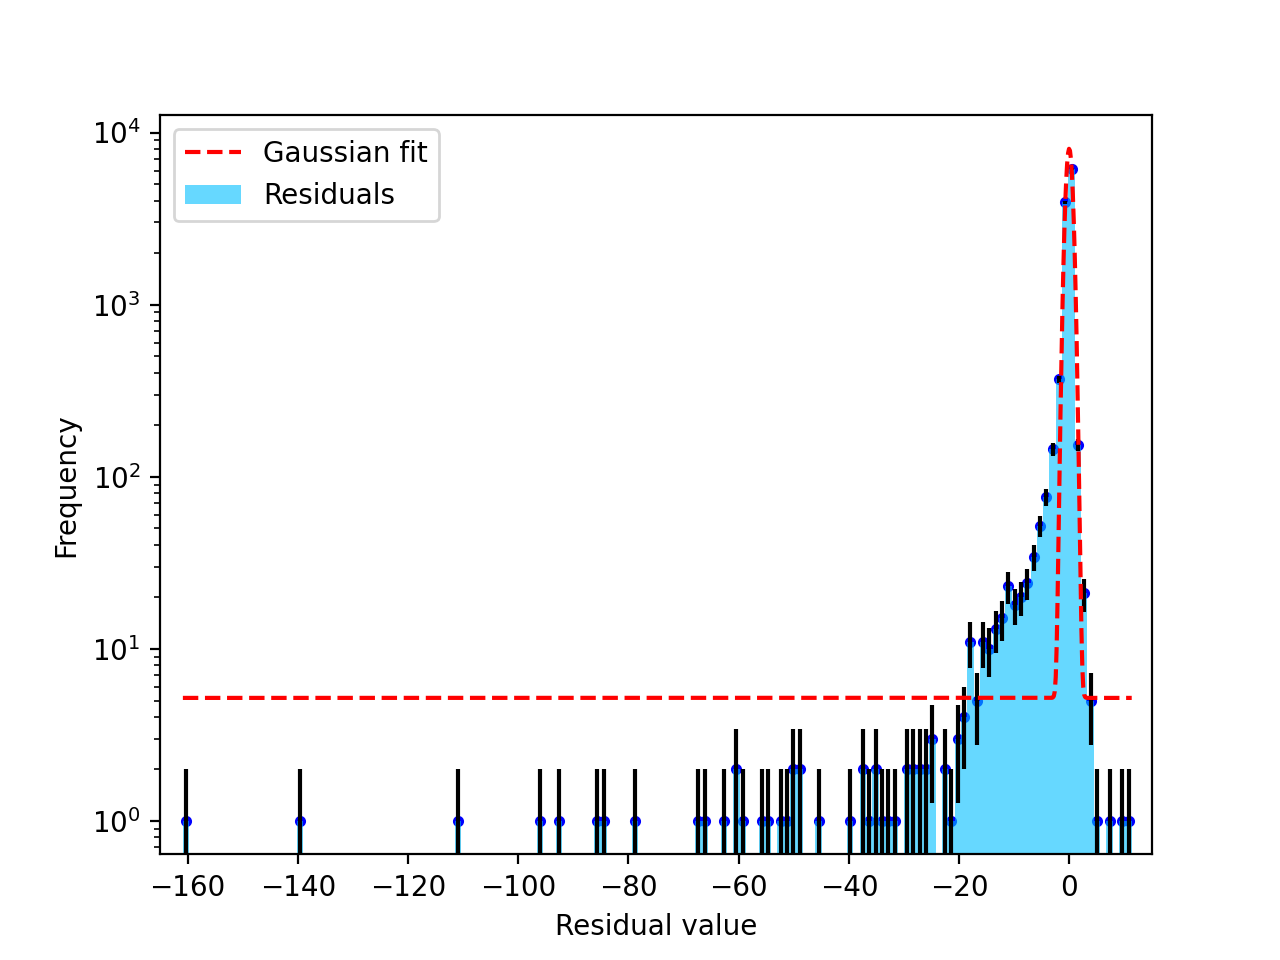

Fit parametres:
 [ 8.04776601e+03 -2.15429938e-02  5.93579807e-01  5.17853915e+00]


In [122]:
print('Max value:',df['residuals'].max())
print('Min value:',df['residuals'].min())
print('Unique values:',df['residuals'].nunique())


def f(x,a,b,c,d):
    return a*np.exp(-pow(x-b,2)/(2*pow(c,2)))+d
    
n_bins=150
x=df['residuals']

%matplotlib notebook
fig=plt.figure()
df['residuals'].plot(kind='hist',bins=n_bins, alpha=0.6,label='Residuals',color='deepskyblue' )

y,binEdges = np.histogram(x,bins=n_bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
yerr = np.sqrt(y)
plt.bar(bincenters, y, width=0, yerr=yerr)

popt, pcov = curve_fit(f, bincenters, y)
x_range=np.linspace(df['residuals'].min(),df['residuals'].max(),1000)
plt.plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)

plt.scatter(bincenters,y,marker='.',color='blue')

plt.xlabel('Residual value')
plt.xlim(-165,15)
plt.yscale('log')
plt.legend(loc='best')

plt.show()


print('Fit parametres:\n', popt)
#print("mu = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
#print("sigma = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
#print("x_0 = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [31]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt 

--2022-01-08 17:21:02--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2022-01-08 17:21:03--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdff2c4ec8b4970c91ed583e49.dl.dropboxusercontent.com/cd/0/inline/BdbVdM4VD95iQEatFWZAzodELs4OCyfS5ZWCSIJYuWj66lfuhiDu0NndtaUZnkhEtRVqPhxH9Idt6n51lyRp2T6hqpPhWXqWcv-4aaqfkjzKiYjXFFjwK_GKKg8vS-XzBPQL9gdY2m8_9IEzmww_bG6k/file# [following]
--2022-01-08 17:21:03--  https://uccdff2c4ec8b4970c91ed583e49.dl.dropboxusercontent.com/

In [36]:
df=pd.read_csv('munich_temperatures_average_with_bad_data.txt')
df.head(10)

,1995.00274 0.944444
0,1995.00548 -1.61111
1,1995.00821 -3.55556
2,1995.01095 -9.83333
3,1995.01369 -10.2222
4,1995.01643 -9.5
5,1995.01916 -10.2222
6,1995.02190 -6.61111
7,1995.02464 -2.94444
8,1995.02738 1.55556
9,1995.03012 0.277778


In [ ]:
def f(x,a,b,c,t):
    return a*np.cos(2*np.pi*t+b)+c